# Test GEModelTools - HANK

This notebook shows how to **solve a simple Heterogenous Agent New Keynessian (HANK) model** using the `GEModelTools` package.

**The steps of the sequence-space solution method are:**

1. Find the stationary equilibrium (steady state for aggregates and distribution).
2. Compute Jacobians of the household block and the full model (to unknowns and shocks)
3. Find the non-linear transition path or the linearized impulse responses to a given shock path.
4. Simulate the linearized model with aggregate risk

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from HANKmodel import HANKModelClass

C:\Users\Signe\AppData\Local\Temp\ipykernel_20152\1560240059.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


# Setup

In [9]:
model = HANKModelClass(name='baseline')
#print(model)

# Step 1: Steady state

In [11]:
model.find_ss(do_print=True)

M_N = 1.0 M_L = nan beta =  0.9875 varphi = 0.8 N_N = 1.0


ZeroDivisionError: division by zero

In [5]:
model.solve_hh_ss(do_print=True)

household problem in ss solved in 1.7 secs [489 iterations]


In [6]:
par = model.par
ss = model.ss
path = model.path
sim = model.sim

## Policy functions

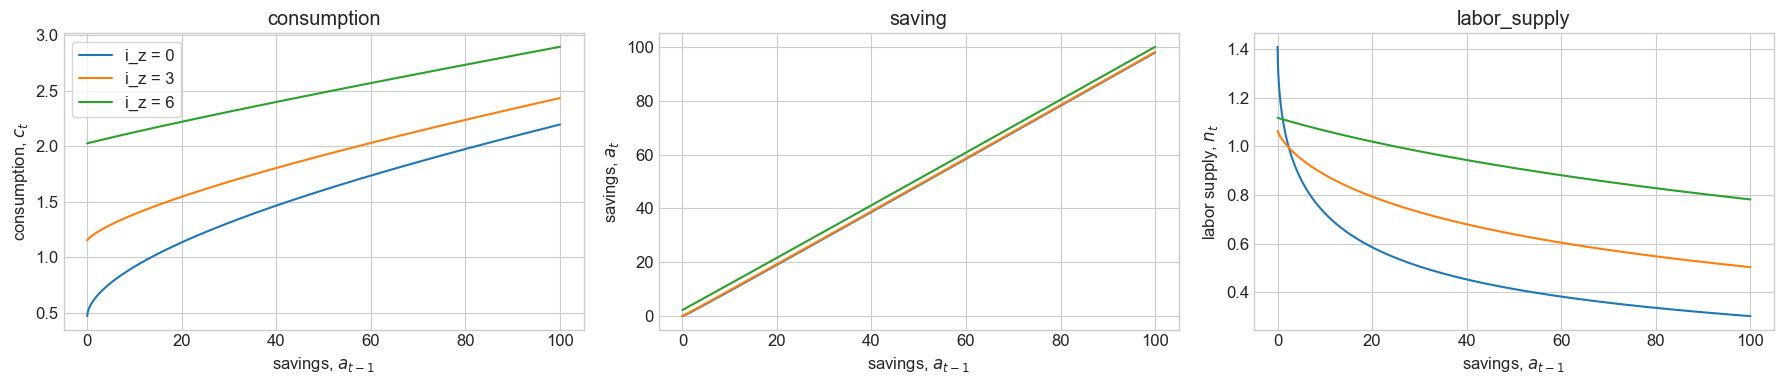

In [7]:
fig = plt.figure(figsize=(18,4),dpi=100)
a_max = 500

# a. consumption
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,1)
ax.set_title(f'consumption')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.c[0,i_z,I],label=f'i_z = {i_z}')

ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('consumption, $c_t$')

# b. saving
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,2)
ax.set_title(f'saving')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.a[0,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('savings, $a_{t}$')

# c. labor supply
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,3)
ax.set_title(f'labor_supply')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.ell[0,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('labor supply, $n_{t}$')

fig.tight_layout()

In [8]:
print("Steady state wage = ", ss.w_L, ss.w_N)
print("Steady state B, G, A, A_HH, tau = ", ss.B, ss.G, ss.A, ss.A_hh, ss.tau)
print("Steady state interest rate", ss.r)
print("steady state consumption", ss.C_hh)
print("Steady state laborsupply ell ", ss.ell)
print("varphi= ", par.varphi, "beta = ", par.beta)

Steady state wage =  0.7389817346930883 0.6232618422973919
Steady state B, G, A, A_HH, tau =  5.6 0.0 5.6 5.600000000000198 0.0
Steady state interest rate 0.0
steady state consumption 1.262777270520561
Steady state laborsupply ell  [[[1.40824621 1.40386654 1.39944748 ... 0.30640852 0.30463119 0.30285964]
  [1.27525062 1.27232967 1.26938004 ... 0.36482251 0.36282618 0.36083444]
  [1.15516979 1.15322135 1.15125261 ... 0.43220197 0.42999613 0.42779294]
  ...
  [1.04824974 1.04819815 1.04814594 ... 0.59437492 0.59185014 0.58932169]
  [1.07214676 1.0721198  1.07209253 ... 0.6877596  0.68516521 0.6825632 ]
  [1.11677218 1.11675465 1.11673691 ... 0.78690442 0.78432078 0.7817254 ]]]
varphi=  0.8 beta =  0.9853268664431385


## Simulation

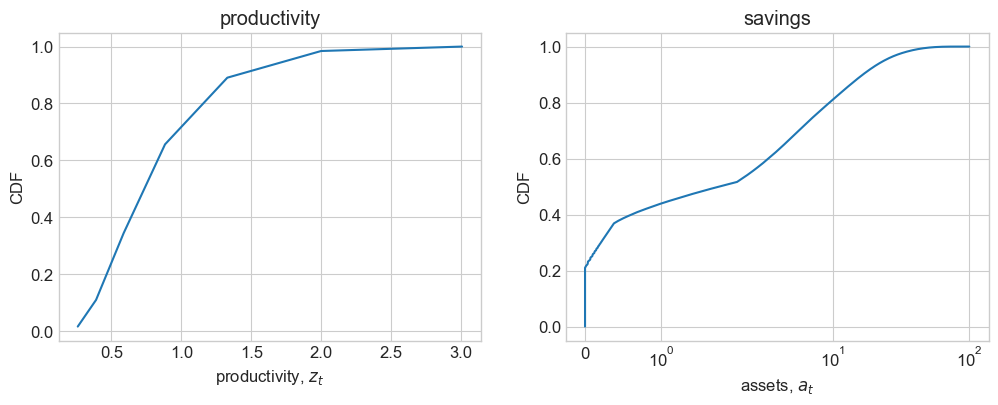

In [9]:
fig = plt.figure(figsize=(12,4),dpi=100)

# a. income
ax = fig.add_subplot(1,2,1)
ax.set_title('productivity')

y = np.cumsum(np.sum(ss.D[0],axis=1))
ax.plot(par.z_grid,y/y[-1])

ax.set_xlabel('productivity, $z_{t}$')
ax.set_ylabel('CDF')

# b. assets
ax = fig.add_subplot(1,2,2)
ax.set_title('savings')
y = np.insert(np.cumsum(np.sum(ss.D[0],axis=0)),0,0.0)
ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),y/y[-1])
        
ax.set_xlabel('assets, $a_{t}$')
ax.set_ylabel('CDF')
ax.set_xscale('symlog')


# Step 2: Compute Jacobians (incl. tests)

**Household transition path:**

note: inputs = steady state value -> expected: constant value (straigt line)

household problem solved along transition path in 3.9 secs
household problem simulated along transition in 6.3 secs



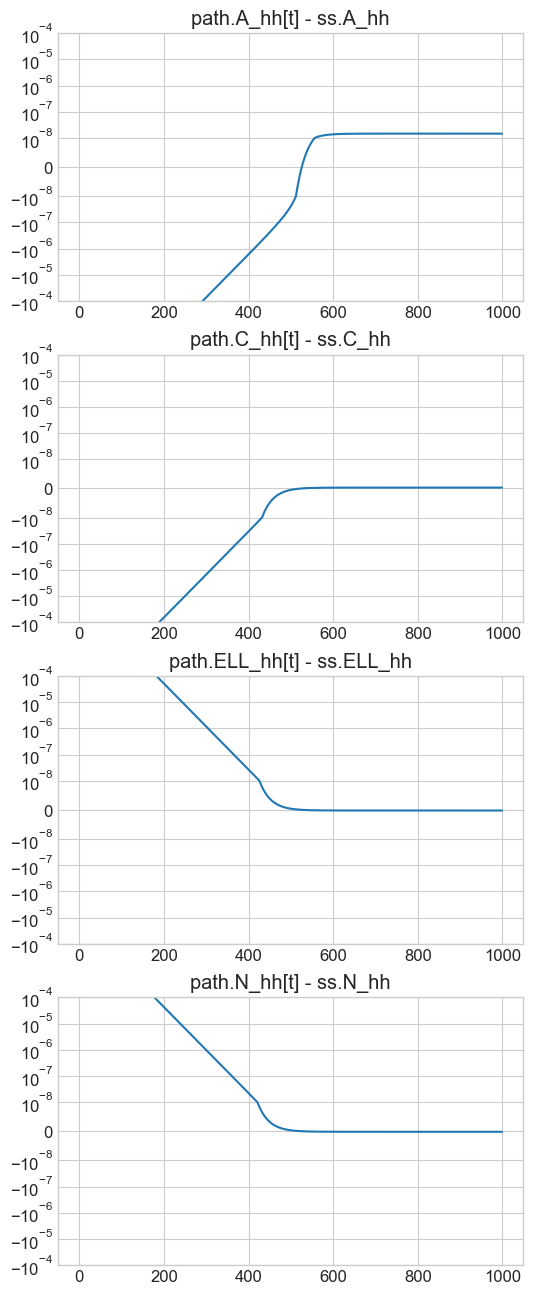

In [10]:
model.test_hh_path()

**Full transition path:**

In [518]:
model.test_path()

note: inputs = steady state value -> expected: no difference to steady state and zero errors

difference to value at steady state:
A              : t0 =  0.0e+00, max abs.  0.0e+00
B              : t0 =  0.0e+00, max abs.  0.0e+00
C              : t0 =  1.2e+00, max abs.  1.2e+00
d_N            : t0 =  3.0e-01, max abs.  3.0e-01
d_L            : t0 =  1.8e-01, max abs.  1.8e-01
G              : t0 =  0.0e+00, max abs.  0.0e+00
i              : t0 =  0.0e+00, max abs.  0.0e+00
N              : t0 =  1.7e+00, max abs.  1.7e+00
M_N            : t0 = -4.7e-01, max abs.  4.7e-01
M_L            : t0 = -3.0e-01, max abs.  3.0e-01
pm             : t0 =  0.0e+00, max abs.  0.0e+00
pi_N           : t0 =  0.0e+00, max abs.  0.0e+00
pi_L           : t0 =  0.0e+00, max abs.  0.0e+00
adjcost        : t0 =  0.0e+00, max abs.  0.0e+00
adjcost_N      : t0 =  0.0e+00, max abs.  0.0e+00
adjcost_L      : t0 =  0.0e+00, max abs.  0.0e+00
r              : t0 =  0.0e+00, max abs.  0.0e+00
istar          : t0

note: differences should only be due to numerical errors

direct method:
finding Jacobian wrt. ghost          : 50 100 150 [computed in 0.8 secs]
finding Jacobian wrt. d_L            : 50 100 150 [computed in 0.8 secs]
finding Jacobian wrt. d_N            : 50 100 150 [computed in 0.8 secs]
finding Jacobian wrt. r              : 50 100 150 [computed in 0.8 secs]
finding Jacobian wrt. tau            : 50 100 150 [computed in 0.7 secs]
finding Jacobian wrt. w_L            : 50 100 150 [computed in 0.8 secs]
finding Jacobian wrt. w_N            : 50 100 150 [computed in 0.8 secs]
household Jacobian computed in 5.9 secs

fake news method:
one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for d_L             in 0.5 secs
curly_Y and curly_D calculated for d_N             in 0.5 secs
curly_Y and curly_D calculated for r               in 0.5 secs
curly_Y and curly_D calculated for tau             in 0.5 secs
curly_Y and curly_D calculated for w_L       

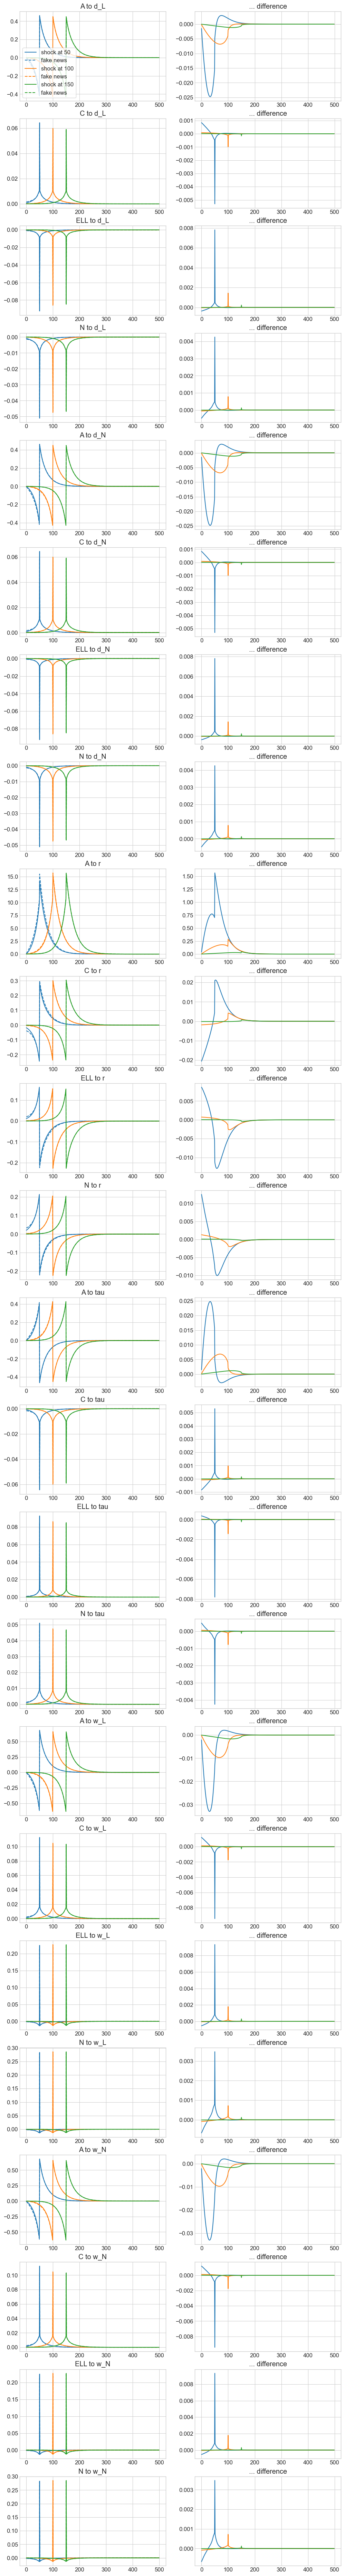

In [509]:
model.test_jacs(s_list=[50,100,150])

# Step 3a: Find non-linear transition path

## Find transition path

In [510]:
par.jump_pm = 0.10/4
model.find_transition_path(do_print=True)

finding the transition path:
 it =   0 -> max. abs. error = 7.13e+00
   7.75e-04 in NKPC_res_N
   4.30e-04 in NKPC_res_L
   7.13e+00 in clearing_A
   1.91e+00 in clearing_N


LinAlgError: Last 2 dimensions of the array must be square

## Plot transitions

### shocks ###


c:\users\johan\onedrive\økonomi ku\speciale\github repositories\numeconcopenhagen\gemodeltools\GEModelTools\figures.py:109: RuntimeWarning: divide by zero encountered in true_divide
  ax.plot(np.arange(T_max),100*(pathvalue[:T_max]/ssvalue-1),label=label)


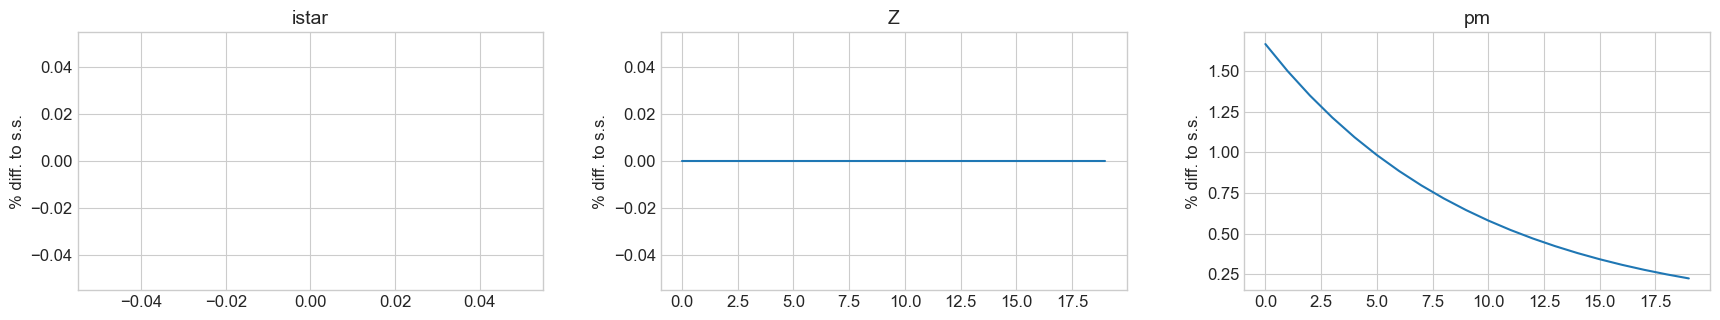


### varnames ###


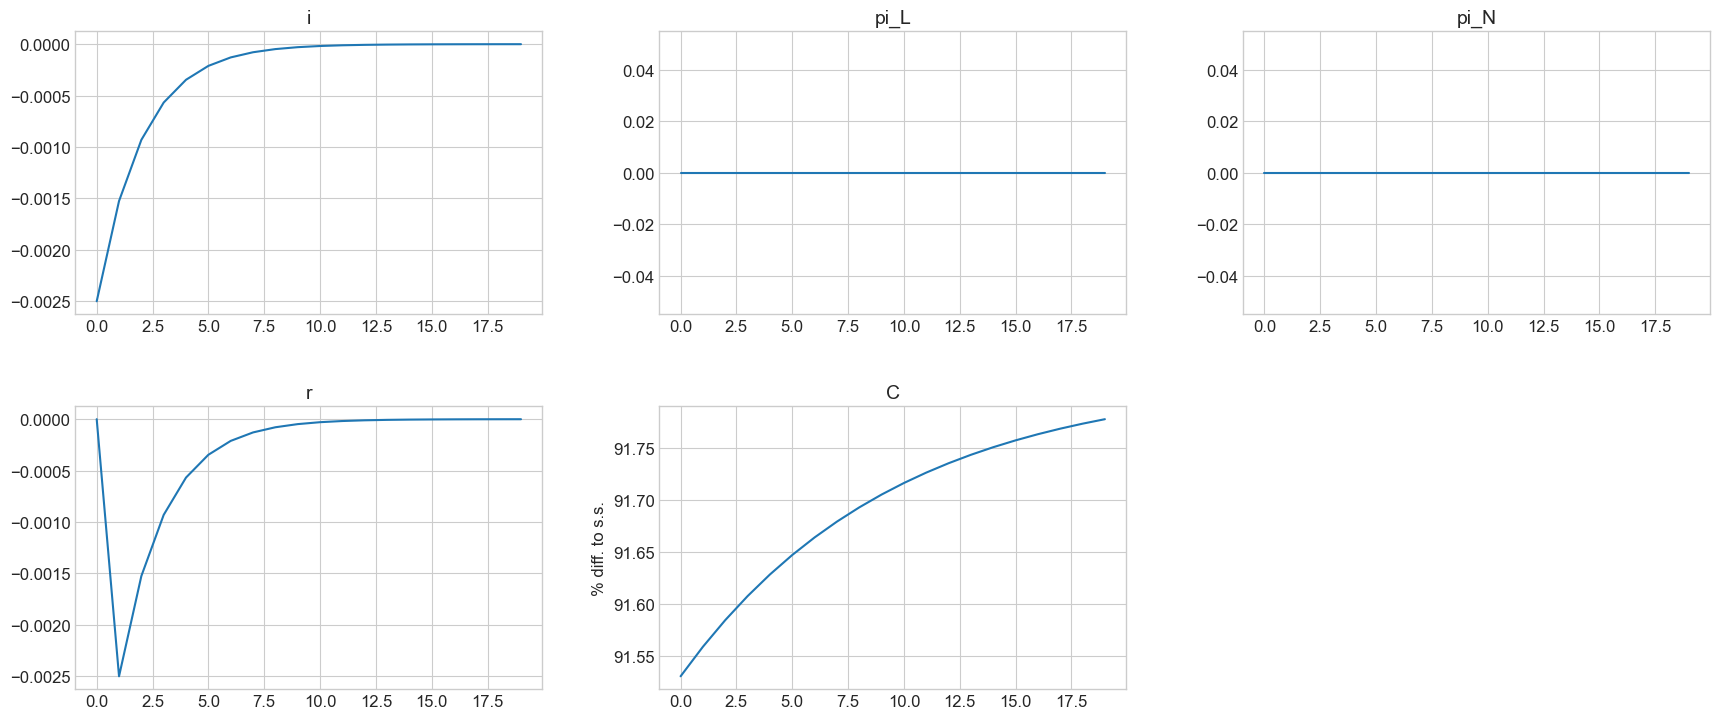


### tagets ###


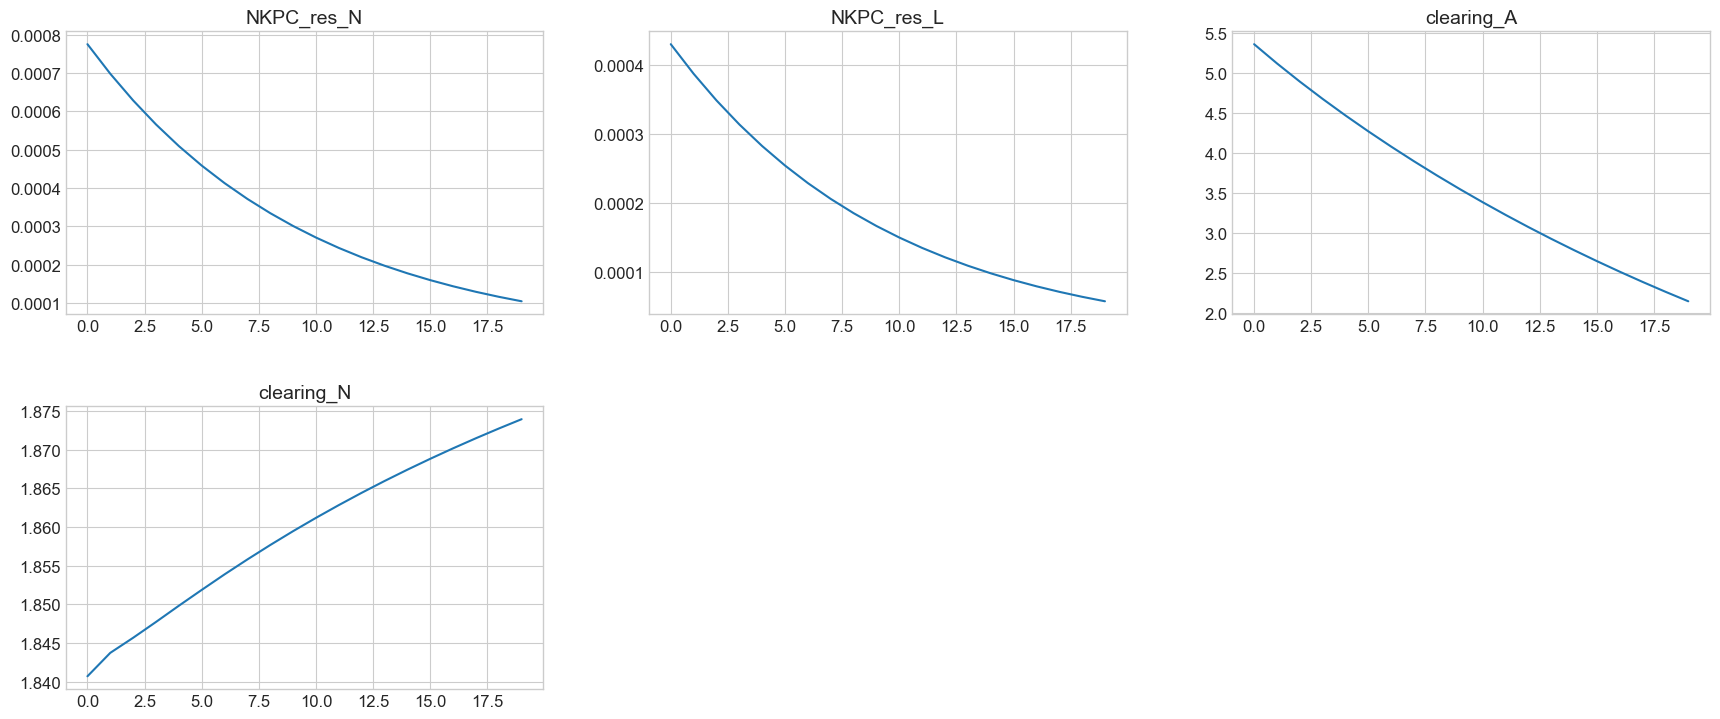

In [511]:
paths = ['i','pi_L','pi_N','r','C']
lvl_value = ['i','pi_L','pi_N','r']
model.show_IRFs(paths,lvl_value=lvl_value,T_max=20,ncols=3)

# Step 3b: Find linearized IRFs

In [478]:
model.find_IRFs(do_print=True)

LinAlgError: Last 2 dimensions of the array must be square

### shocks ###


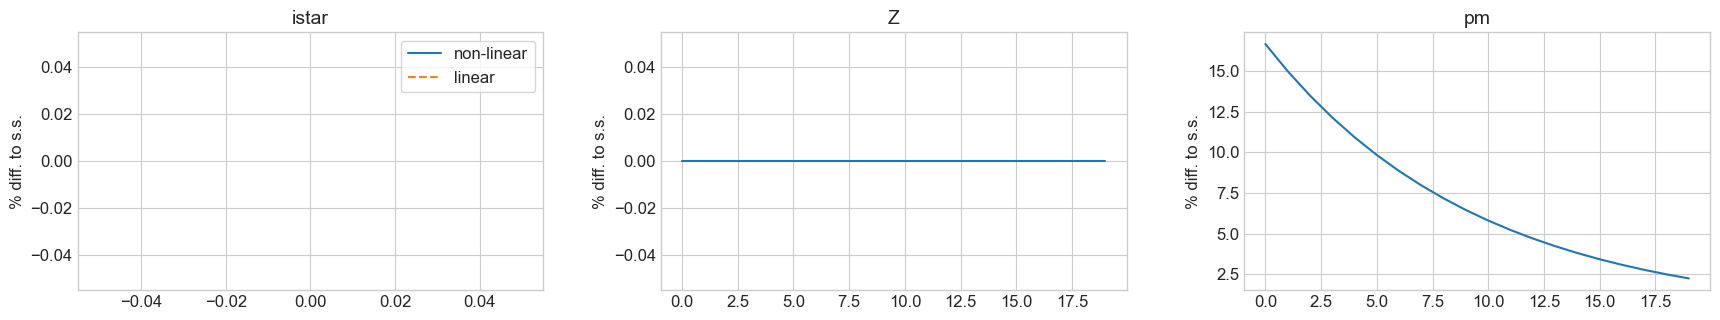


### varnames ###


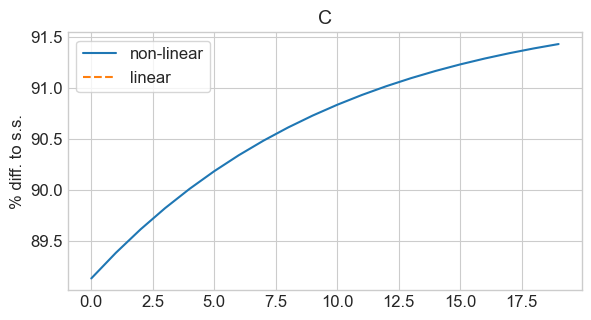


### tagets ###


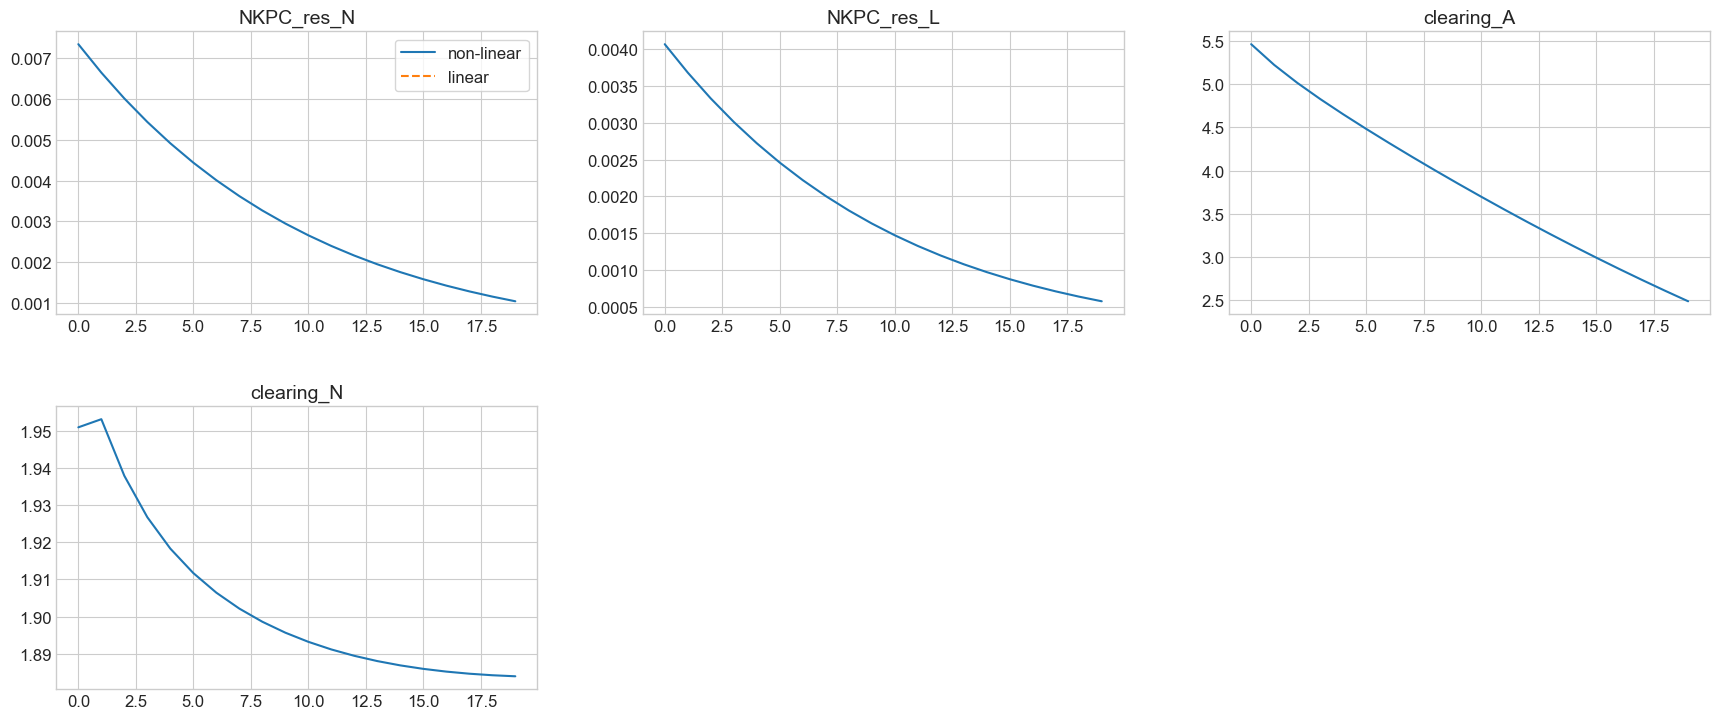

In [479]:
paths = ['C']
model.show_IRFs(paths,T_max=20,ncols=3,do_linear=True)

# Step 4. Simulation

In [ ]:
np.random.seed(1917)
model.simulate(do_print=True)

In [ ]:
def model_sim():
    
    fig = plt.figure(figsize=(12,8),dpi=100)

    ax = fig.add_subplot(2,2,1)
    ax.set_title('i')
    ax.plot(ss.i+sim.di,ls='--')
    ax.axhline(ss.i,color='black',zorder=0)

    ax = fig.add_subplot(2,2,2)
    ax.set_title('pi')
    ax.plot(ss.pi+sim.dpi,ls='--',)
    ax.axhline(ss.pi,color='black',zorder=0)
    
    ax = fig.add_subplot(2,2,3)
    ax.set_title('r')
    ax.plot(ss.r+sim.dr,ls='--',)
    ax.axhline(ss.r,color='black',zorder=0)
    
    ax = fig.add_subplot(2,2,4)
    ax.set_title('C')
    ax.plot(ss.C+sim.dC,ls='--',)
    ax.axhline(ss.C,color='black',zorder=0)
    

In [ ]:
model_sim()